## Load rs-fMRI dataset

In [5]:
from nilearn import datasets

# Add dataset to Original_Data and include all confounds
data = datasets.fetch_development_fmri(data_dir='../Original_Data', reduce_confounds=False)

In [9]:
from datalad import api

api.create(path='../Original_Data', force=True)

[INFO] Creating a new annex repo at /Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data 


<Dataset path=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data>

In [10]:
api.save(path='../Original_Data', message='Fetch development_fMRI dataset using Nilearn and create DataLad dataset')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/participants.tsv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/sub-pixar001_task-pixar_desc-confounds_regressors.tsv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Dat

In [113]:
api.create(path='../Analysis_Data', force=True)

[INFO] Creating a new annex repo at /Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data 


<Dataset path=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data>

In [114]:
api.save(path='../Analysis_Data', message='Create DataLad dataset for data generated by analysis')

[{'action': 'save',
  'type': 'dataset',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project',
  'status': 'notneeded'}]

## Load phenotypic information

In [33]:
import pandas

pheno = pandas.DataFrame(data.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


### Assess class balance

In [34]:
y_age = pheno['Age']

age_class = pheno['AgeGroup']
age_class.value_counts()

8-12yo    34
5yo       34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64

## Functional atlas

### Load BASC multiscale atlas

In [6]:
# Load atlas with 64 ROIs
parcellations_basc = datasets.fetch_atlas_basc_multiscale_2015(data_dir='../Original_Data')
atlas_filename_basc = parcellations_basc.scale064

In [30]:
api.save(path='../Original_Data/basc_multiscale_2015', message='Download BASC multiscale atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/README.md',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale012.nii.gz',
  'type': 'file',
  'refds': '/Users/Stor

### Plot atlas

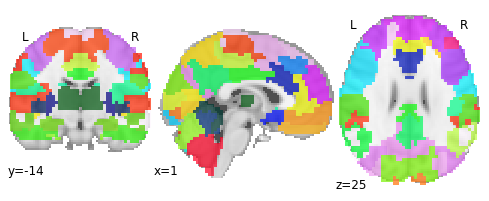

In [18]:
from nilearn import plotting

plotting.plot_roi(atlas_filename_basc, draw_cross=False)

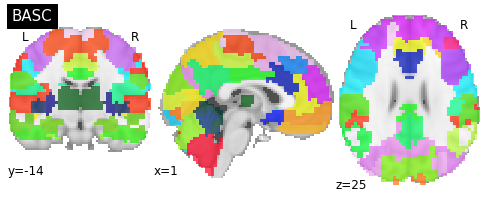

In [272]:
#display = plotting.plot_roi(atlas_filename_basc, draw_cross=False, title="BASC")
#display.savefig('BASC.png')

### Feature extraction for computing correlation matrices

In [3]:
# Define function for initializing label masker

def mask_init_labels(atlas):
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True, 
                           memory='nilearn_cache', verbose=0)
    return masker

In [8]:
# Define function for initializaing connectivity measures

def corr_measure(diag):
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=diag)               # Keep/Discard diagonal
    return correlation_measure

In [9]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

masker = mask_init_labels(atlas=atlas_filename_basc)

correlation_measure = corr_measure(diag=False)

In [46]:
# Define function to extract features for visualization of individual correlation matrices

def feat_extract_corr(masker, correlation_measure):
    all_features = [] # Empty list for containing all features (correlations)
    
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=data.confounds[i])
        # Create region x region correlation matrix
        correlation_matrix_ind = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix_ind)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)

        ind_matrices = vec_to_sym_matrix(X_features)
        
    return time_series, ind_matrices

In [23]:
from nilearn.connectome import vec_to_sym_matrix
import numpy as np

# Extract features for generatin of individual correlation matrices
time_series, ind_matrices = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix for subject

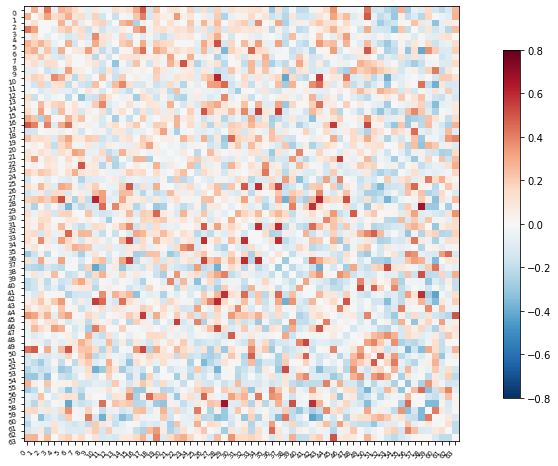

In [25]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices[subject], 0)

plotting.plot_matrix(ind_matrices[subject], figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

### Feature extraction for model

In [26]:
# Define function to extract features for support vector regression model

def feat_extract_model(masker, correlation_measure):
    all_features = [] # Empty list for containing all features (correlations)
    
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=data.confounds[i])
        # Create region x region correlation matrix
        correlation_matrix_ind = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix_ind)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)
        
    return X_features

In [28]:
# Perform feature extraction

correlation_measure = corr_measure(diag=True)

X_features = feat_extract_model(masker, correlation_measure)

### Plot feature matrix

Text(0, 0.5, 'Subjects')

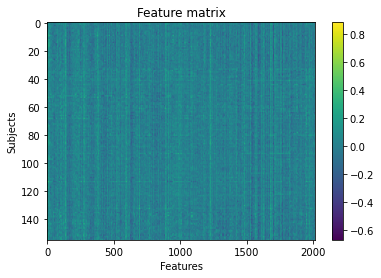

In [29]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('Feature matrix')
plt.xlabel('Features')
plt.ylabel('Subjects')

### Define model for age prediction

In [30]:
from sklearn.svm import SVR
l_svr = SVR(kernel='linear')

### Generate training/validation splits

In [37]:
# Define function for generating training/validation splits
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

def train_val(X_features, y_age, age_class):
    n_splits = 10

    X_train_container = []
    X_val_container = []
    y_train_container = []
    y_val_container = []

    for i in range(n_splits):
        X_train, X_val, y_train, y_val = train_test_split(
                                                        X_features, # x
                                                        y_age, # y
                                                        test_size = 0.25, # 75%/25% split  
                                                        shuffle = True, # Shuffle dataset
                                                                        # before splitting
                                                        stratify = age_class,  # keep
                                                                               # distribution
                                                                               # of ageclass
                                                                               # consistent
                                                                               # betw. train
                                                                               # & test sets.
                                                                           )

        X_train_container.append(X_train)
        X_val_container.append(X_val)
        y_train_container.append(y_train)
        y_val_container.append(y_val)
    
    # Print size of our training and test groups
    print('training:', len(X_train),
         'testing:', len(X_val))
    
    return X_train_container, X_val_container, y_train_container, y_val_container

In [38]:
from sklearn.model_selection import train_test_split

X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features, y_age, age_class)

training: 116 testing: 39


### Fit model to training data using 10-fold CV

In [39]:
# Define function for fitting model to training data using 10-fold cross-validation

def model_fit(X_train_container, y_train_container):
    # Build a tiny pipeline that does feature selection (top 20% of features), 
    # and then prediction with our linear svr model.
    model = Pipeline([
        ('feature_selection',SelectPercentile(f_regression,percentile=20)),
        ('prediction', l_svr)
                     ])
    y_pred_all = []
    y_index_all = []

    for j in range(len(X_train_container)):

        y_pred = [] # Container to catch predictions from each fold
        y_index = [] # Index for each prediction

        # First we create 10 splits of the data
        skf = KFold(n_splits=10, shuffle=True, random_state=123)

        # For each split, assemble the train and test samples 
        for tr_ind, te_ind in skf.split(X_train_container[j]):
            X_tr = X_train_container[j][tr_ind]
            y_tr = y_train_container[j].values[tr_ind]
            X_te = X_train_container[j][te_ind]
            y_index += list(te_ind) # Store the index of samples to predict
    
            # Run pipeline 
            model.fit(X_tr, y_tr) # Fit data to the model using mini pipeline
            predictions = model.predict(X_te).tolist() # Get predictions for this fold
            y_pred += predictions # Add to list of predictions
        
        y_index_all.append(y_index)
        y_pred_all.append(y_pred)
        
    return y_index_all, y_pred_all

In [41]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

### Evaluate model using accuracy and mean absolute error

Mean R2: 0.6521592372901218
Mean MAE: 3.260674556356065


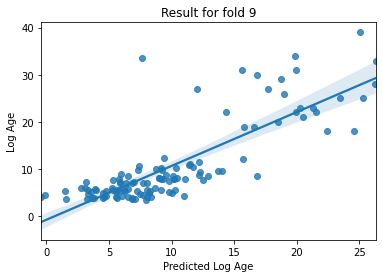

In [43]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [286]:
import scipy.io as sio

sio.savemat('atlas1.mat', {'y_pred_all': y_pred_all[k], 'y_train_container': np.array(y_train_container)[k][y_index_all[k]]})

## Structural atlas

### Load AAL atlas

In [44]:
# Load atlas with 64 ROIs
parcellations_aal = datasets.fetch_atlas_aal(data_dir='../Original_Data')
atlas_filename_aal = parcellations_aal.maps

In [32]:
api.save(path='../Original_Data/aal_SPM12', message='Download AAL atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/aal_SPM12/aal/ROI_MNI_V4.nii',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/aal_SPM12/aal/ROI_MNI_V4.txt',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/aal_SPM12/aal/ROI_MNI_V4.xml',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data

### Plot atlas

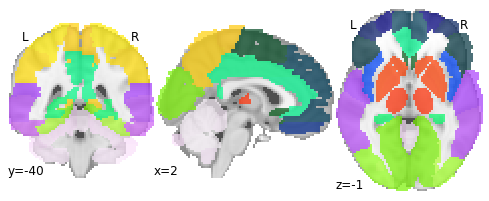

In [34]:
plotting.plot_roi(atlas_filename_aal, draw_cross=False)

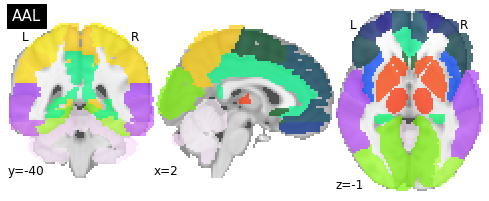

In [276]:
display = plotting.plot_roi(atlas_filename_aal, draw_cross=False, title="AAL")
display.savefig('AAL.png')

### Feature extraction for computing correlation matrices

In [47]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series, ind_matrices = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix

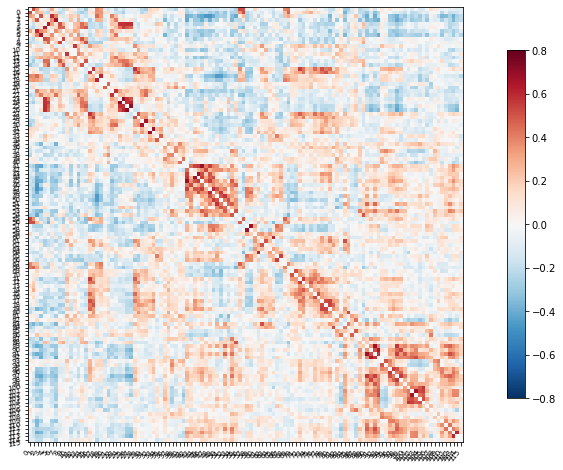

In [48]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices[subject], 0)

plotting.plot_matrix(ind_matrices[subject], figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.6573793943284957
Mean MAE: 3.5505747793526643


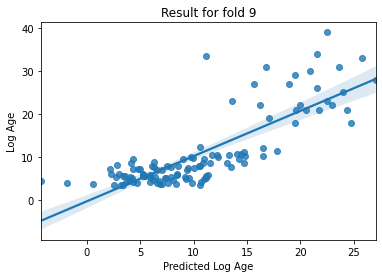

In [49]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [290]:
import scipy.io as sio

sio.savemat('atlas2.mat', {'y_pred_all1': y_pred_all[k], 'y_train_container1': np.array(y_train_container)[k][y_index_all[k]]})


## Clustering method atlas

In [50]:
parcellations_crad = datasets.fetch_atlas_craddock_2012(data_dir='../Original_Data')
atlas_filename_crad = parcellations_crad.random

In [46]:
api.save(path='../Original_Data/craddock_2012', message='Download Craddock atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/craddock_2012/random_all.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/craddock_2012/scorr05_2level_all.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/craddock_2012/scorr05_mean_all.nii.gz',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs202

### Plot atlas

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


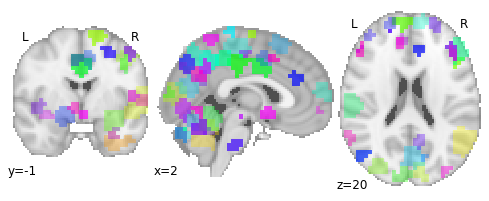

In [51]:
plotting.plot_prob_atlas(atlas_filename_crad, view_type='continuous', draw_cross=False)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning:

empty mask

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning:




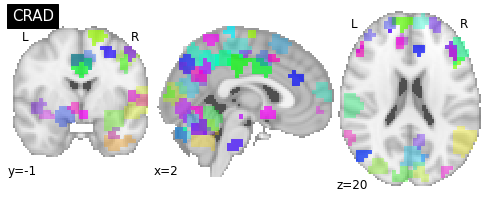

In [280]:
display = plotting.plot_prob_atlas(atlas_filename_crad, view_type='continuous', draw_cross=False, title="CRAD")
display.savefig('CRAD.png')

### Feature extraction for computing correlation matrices

In [54]:
# Define function for initializing map masker (used for probabilistic atlases)

def mask_init_maps(atlas):
    masker = NiftiMapsMasker(maps_img=atlas, standardize=True, 
                           memory='nilearn_cache', verbose=0)
    return masker

In [56]:
from nilearn.input_data import NiftiMapsMasker

# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series, ind_matrices = feat_extract_corr(masker, correlation_measure)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


### Plot correlation matrix

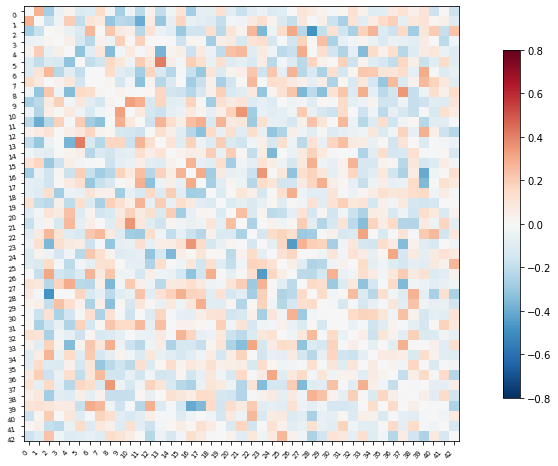

In [57]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices[subject], 0)

plotting.plot_matrix(ind_matrices[subject], figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.5097219341601865
Mean MAE: 3.6968620192866917


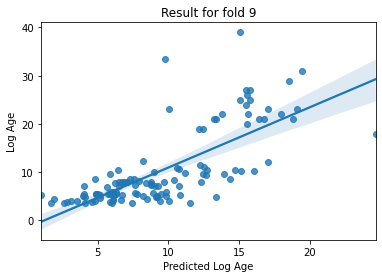

In [58]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [317]:
sio.savemat('atlas3.mat', {'y_pred_all2': y_pred_all[k], 'y_train_container2': np.array(y_train_container)[k][y_index_all[k]]})


## Linear decomposition methods atlas

In [59]:
parcellations_msdl = datasets.fetch_atlas_msdl(data_dir='../Original_Data')
atlas_filename_msdl = parcellations_msdl.maps

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [60]:
api.save(path='../Original_Data/msdl_atlas', message='Download MSDL atlas')

[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/msdl_atlas/MSDL_rois/README.txt',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data/msdl_atlas/MSDL_rois/msdl_rois_labels.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Original_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'save',
  'type': 'dataset',
  'path': '/Users/Storme/brainhack/Project/

### Plot atlas

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


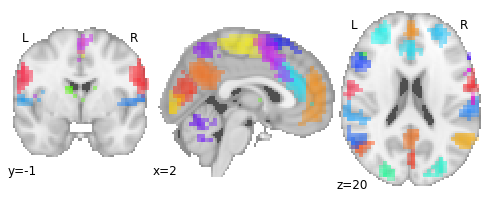

In [61]:
plotting.plot_prob_atlas(atlas_filename_msdl, view_type='continuous', draw_cross=False)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning:




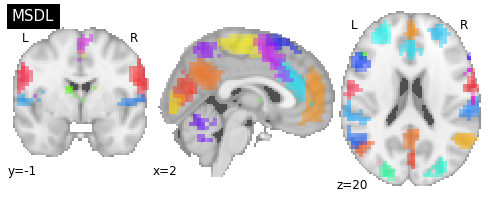

In [279]:
display = plotting.plot_prob_atlas(atlas_filename_msdl, view_type='continuous', draw_cross=False, title="MSDL")
display.savefig('MSDL.png')

### Feature extraction for computing correlation matrices

In [62]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series, ind_matrices = feat_extract_corr(masker, correlation_measure)

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


### Plot correlation matrix

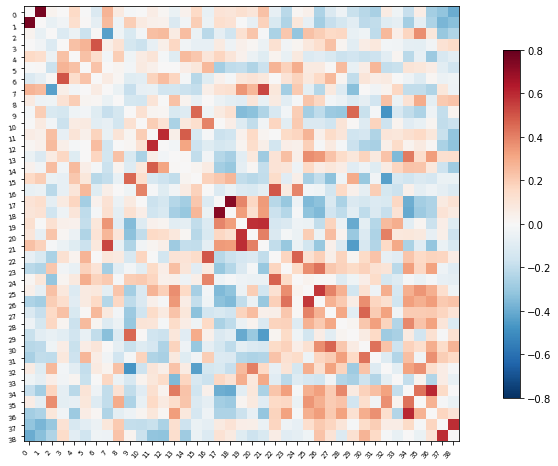

In [63]:
# Mask out major diagonal
np.fill_diagonal(ind_matrices[40], 0)

plotting.plot_matrix(ind_matrices[40], figure=(10, 8),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)

### Perform SVR analysis

training: 116 testing: 39
Mean R2: 0.45451864019362864
Mean MAE: 4.206199145941482


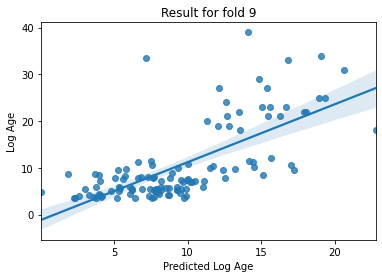

In [64]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [321]:
sio.savemat('atlas4.mat', {'y_pred_all3': y_pred_all[k], 'y_train_container3': np.array(y_train_container)[k][y_index_all[k]]})


# Explore confounds

## Functional atlas-CSF

### Feature extraction for model

In [205]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_basc, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['white_matter','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

In [206]:
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 116 testing: 39


### Fit model to training data using 10-fold cross-validation

In [207]:
# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

R2: 0.6602428134710903
MAE: 3.1635245029510375


Text(0, 0.5, 'Log Age')

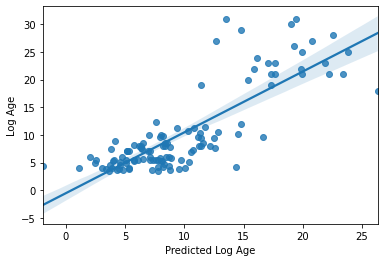

In [208]:
# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Functional atlas-white matter

### Feature extraction for model

In [248]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_basc, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['csf','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_WM_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_WM_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

In [249]:
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 116 testing: 39


### Fit model to training using 10-fold cross-validation

In [250]:
# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

R2: 0.6352065996729948
MAE: 3.2348247548360884


Text(0, 0.5, 'Log Age')

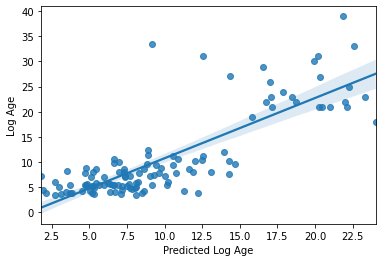

In [251]:
# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Functional atlas-global signal

### Feature extraction for model

In [252]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_basc, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['csf','white_matter'], axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_global_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_global_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

In [253]:
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 116 testing: 39


### Fit model to training using 10-fold cross-validation

In [254]:
# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

R2: 0.6633812513488418
MAE: 3.006244618299418


Text(0, 0.5, 'Log Age')

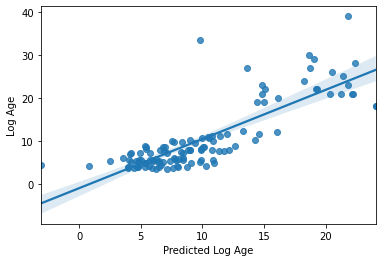

In [255]:
# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Functional atlas-motion

### Feature extraction for model

In [217]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_basc, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop('framewise_displacement', axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_motion_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_motion_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

In [218]:
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 116 testing: 39


### Fit model to training using 10-fold cross-validation

In [219]:
# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

R2: 0.6511407529124575
MAE: 2.8655549901269985


Text(0, 0.5, 'Log Age')

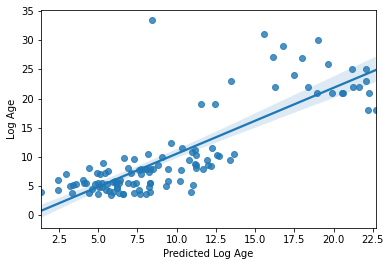

In [220]:
# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Structural atlas-CSF

### Feature extraction for model

In [221]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_aal, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['white_matter','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/aal_CSF_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/aal_CSF_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

In [222]:
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

training: 116 testing: 39


### Fit model to training using 10-fold cross-validation

In [223]:
# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

R2: 0.7244324649125369
MAE: 3.121985515144057


Text(0, 0.5, 'Log Age')

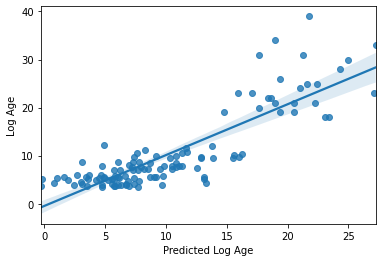

In [224]:
# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Structural atlas-white matter

training: 116 testing: 39
R2: 0.6346302264957785
MAE: 3.3941559550280904


Text(0, 0.5, 'Log Age')

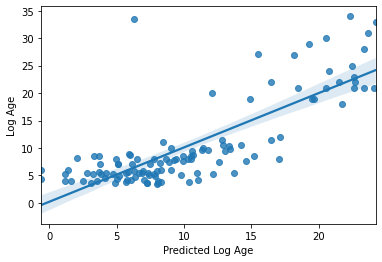

In [225]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_aal, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['csf','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/aal_WM_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/aal_WM_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Structural atlas-global signal

### Feature extraction for model

training: 116 testing: 39
R2: 0.6756809932645295
MAE: 3.192550003169324


Text(0, 0.5, 'Log Age')

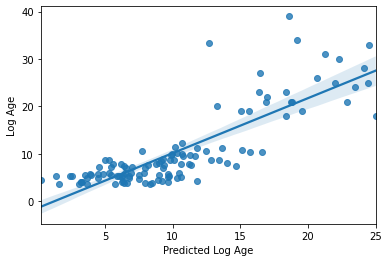

In [226]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_aal, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['csf','white_matter'], axis=1)
    conf_csf.to_csv('../Analysis_Data/aal_global_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/aal_global_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Structural atlas-motion

### Feature extraction for model

training: 116 testing: 39
R2: 0.6544383596155902
MAE: 3.512655770863372


Text(0, 0.5, 'Log Age')

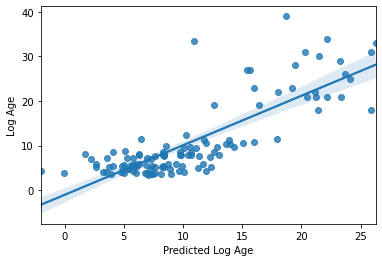

In [227]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename_aal, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop('framewise_displacement', axis=1)
    conf_csf.to_csv('../Analysis_Data/aal_motion_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/aal_motion_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Clustering method atlas-CSF

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
R2: 0.5163691069254541
MAE: 3.8793008062098577


Text(0, 0.5, 'Log Age')

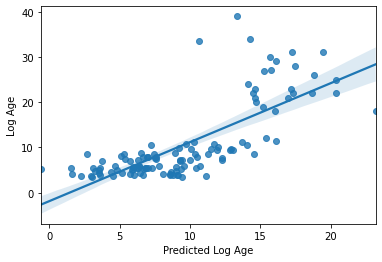

In [245]:
### Feature extraction for model

# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_crad, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['white_matter','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/crad_CSF_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/crad_CSF_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Clustering method atlas-white matter

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
R2: 0.48364460987356717
MAE: 3.837551539470065


Text(0, 0.5, 'Log Age')

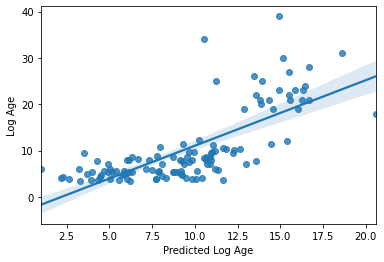

In [256]:
### Feature extraction for model
# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_crad, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['csf','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/crad_WM_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/crad_WM_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Clustering method atlas-global signal

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
R2: 0.46477233340541446
MAE: 3.7007954144838293


Text(0, 0.5, 'Log Age')

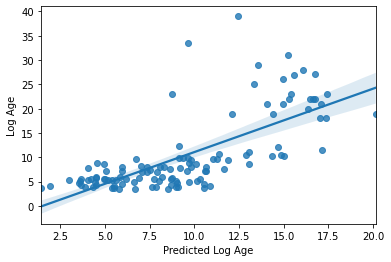

In [257]:
### Feature extraction for model

# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_crad, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['csf','white_matter'], axis=1)
    conf_csf.to_csv('../Analysis_Data/crad_global_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/crad_global_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Clustering method atlas-motion

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


training: 116 testing: 39
R2: 0.5134519220778637
MAE: 3.806544238403716


Text(0, 0.5, 'Log Age')

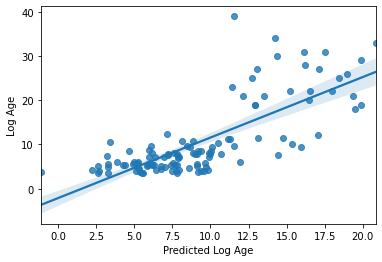

In [258]:
### Feature extraction for model

# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_crad, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop('framewise_displacement', axis=1)
    conf_csf.to_csv('../Analysis_Data/crad_motion_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/crad_motion_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

In [262]:
import plotly.express as px
import pandas as pd
#y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]]
df = pd.DataFrame(dict(R1=y_pred_all[k], NOS=np.array(y_train_container)[k][y_index_all[k]]))
px.scatter(df, x="R1", y="NOS" ,labels={'x':'R1', 'y':'NOS'}, trendline="ols").show()


ModuleNotFoundError: No module named 'statsmodels'

## Linear decomposition methods atlas-CSF

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning:

memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.



training: 116 testing: 39
R2: 0.4771492574126145
MAE: 3.7223869926752435


Text(0, 0.5, 'Log Age')

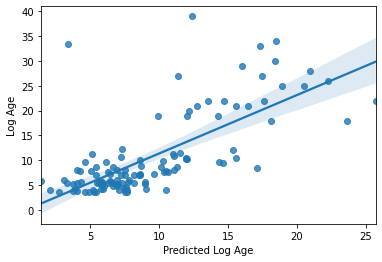

In [263]:
### Feature extraction for model

# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_msdl, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['white_matter','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Linear decomposition methods atlas-white matter

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning:

memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.



training: 116 testing: 39
R2: 0.518652509090032
MAE: 3.897673287328459


Text(0, 0.5, 'Log Age')

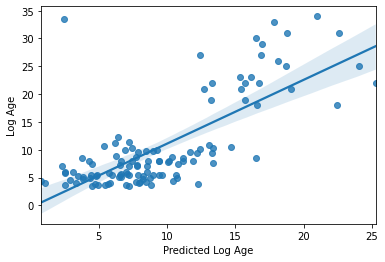

In [264]:
### Feature extraction for model

# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_msdl, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['white_matter','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Linear decomposition methods atlas-global signal

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning:

memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.



training: 116 testing: 39
R2: 0.5276779644176239
MAE: 3.9462145852128185


Text(0, 0.5, 'Log Age')

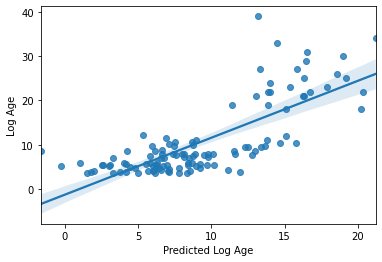

In [265]:
### Feature extraction for model

# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_msdl, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['white_matter','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

## Linear decomposition methods atlas-motion

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning:

memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.



training: 116 testing: 39
R2: 0.5196312248009864
MAE: 3.6592577900210204


Text(0, 0.5, 'Log Age')

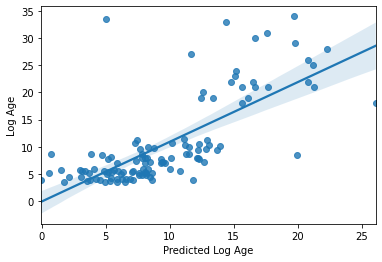

In [266]:
### Feature extraction for model

# Initialize masker
masker = NiftiMapsMasker(maps_img=atlas_filename_msdl, standardize=True,
                         memory='nilearn_cache', verbose=0)

# Initialize correlation measure for SVR model
# Set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=True)               # Discard diagonal

all_features = [] # Empty list for containing all features (correlations)

# Extract signal based on labels defined by atlas
for i,sub in enumerate(data.func):
    # Define confounds
    conf = pandas.read_csv(data.confounds[i],sep='\t')
    conf_csf = conf.drop(['white_matter','global_signal'], axis=1)
    conf_csf.to_csv('../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Extract timeseries from each ROI in atlas
    time_series = masker.fit_transform(sub, confounds='../Analysis_Data/basc_CSF_{}.csv'.format(i))
    # Create region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # Add correlation matrix to feature container
    all_features.append(correlation_matrix)
    # Track progress
    #print('finished %s of %s'%(i+1,len(data.func)))
    
# Convert feature list to numpy array
X_features = np.array(all_features)


### Get training/validation splits

# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

n_val = 10

X_train_container = []
X_val_container = []
y_train_container = []
y_val_container = []

for i in range(n_val):
    X_train, X_val, y_train, y_val = train_test_split(
                                                    X_features, # x
                                                    y_age, # y
                                                    test_size = 0.25, # 75%/25% split  
                                                    shuffle = True, # Shuffle dataset
                                                                    # before splitting
                                                    stratify = age_class,  # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    #random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

    X_train_container.append(X_train)
    X_val_container.append(X_val)
    y_train_container.append(y_train)
    y_val_container.append(y_val)
    
# Print size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_val))

### Fit model to training using 10-fold cross-validation

# Build a tiny pipeline that does feature selection (top 20% of features), 
# and then prediction with our linear svr model.
model = Pipeline([
    ('feature_selection',SelectPercentile(f_regression,percentile=20)),
    ('prediction', l_svr)
                 ])
y_pred_all = []
y_index_all = []

for j in range(len(X_train_container)):

    y_pred = [] # a container to catch the predictions from each fold
    y_index = [] # just in case, the index for each prediction

    # First we create 10 splits of the data
    skf = KFold(n_splits=10, shuffle=True, random_state=123)

    # For each split, assemble the train and test samples 
    for tr_ind, te_ind in skf.split(X_train_container[j]):
        X_tr = X_train_container[j][tr_ind]
        y_tr = y_train_container[j].values[tr_ind]
        X_te = X_train_container[j][te_ind]
        y_index += list(te_ind) # store the index of samples to predict
    
        # and run our pipeline 
        model.fit(X_tr, y_tr) # fit the data to the model using our mini pipeline
        predictions = model.predict(X_te).tolist() # get the predictions for this fold
        y_pred += predictions # add them to the list of predictions
        
    y_index_all.append(y_index)
    y_pred_all.append(y_pred)

# Check CV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

k=9

acc = r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k])
mae = mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k])

print('R2:',acc)
print('MAE:',mae)

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

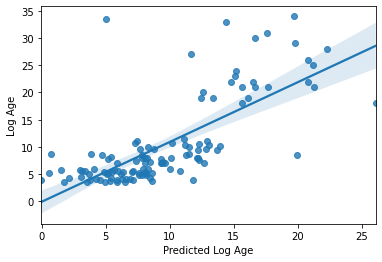

In [270]:
sns_plot = sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

sns_plot.figure.savefig("regression.png")

In [2]:
from datalad import api

api.save(path='../Analysis_Data', message='Add all .csv files generated for confound analysis to Analysis_Data')


[WARNING] realpath of PWD=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project is /Users/Storme/brainhack/Project/stephaniealley_bhs2020_project whenever os.getcwd()=/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Command_Files. From now on will be returning os.getcwd(). Directory symlinks in the paths will be resolved 


[{'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_0.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_1.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_10.csv',
  'type': 'file',
  'refds': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data',
  'status': 'ok',
  'message': '',
  'key': None},
 {'action': 'add',
  'path': '/Users/Storme/brainhack/Project/stephaniealley_bhs2020_project/Analysis_Data/aal_CSF_100.csv',
  'type': 'file',
  'refd